<h1 align="center"><b>ANOVA - Models x Aggregation Technique</b></h1>
<h3 align="center"><b style="color:gray">Classification of Companies' Economic Activity: A Web Content and Machine Learning-Based Approach</b></h1>

<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
    <li><a href="#data"><h5>1. Data</h5></a></li>
    <li><a href="#anova"><h5>2. Two-way ANOVA (Analysis of variance)</h5></a></li>
    <li><a href="#ttest"><h5>3. Student's t-test</h5></a></li>
    <ul style = "list-style-type: none;">
        <li><a href="#model"><h5>3.1. Model</h5></a></li>
        <li><a href="#preprocessing"><h5>3.2. Preprocessing (Aggregation Technique)</h5></a></li>
        <li><a href="#interaction"><h5>3.3. Interaction (Model x Preprocessing)</h5></a></li>
    </ul>
    <li><a href="#conclusion"><h5>4. Conclusion</h5></a></li>
    <li><a href="#references"><h5>5. References</h5></a></li>
</ul>

In [1]:
import json
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

def clean_anova(df):
    anova_clean = (
        df.rename(columns={
            "SS": "Sum Sq",
            "DF": "df",
            "MS": "Mean Sq",
            "F": "F-value",
            "p-unc": "p-value",
            "np2": "Eta² (partial)"
        })
        .round({
            "Sum Sq": 6,
            "Mean Sq": 6,
            "F-value": 3,
            "Eta² (partial)": 3
        })
    )
    anova_clean = anova_clean[[
        "Source",
        "df",
        "Sum Sq",
        "Mean Sq",
        "F-value",
        "p-value",
        "Eta² (partial)"
    ]]
    display(anova_clean)
    return anova_clean

def clean_posthoc(df):
    df_clean = (
        df.rename(columns={
            "A": "Group 1",
            "B": "Group 2",
            "T": "t-value",
            "p-unc": "p-value",
            "p-corr": "p-value adj",
            "hedges": "Hedges g",
            "BF10": "BF10"
        })
        .round({
            "t-value": 4,
            "p-value": 6,
            "p-value adj": 6,
            "Hedges g": 3,
            "BF10": 3
        })
    )
    cols = [
        "Group 1", "Group 2", "t-value", "p-value", 
        "p-value adj", "Hedges g", "BF10"
    ]
    df_clean = df_clean[cols]
    display(df_clean)
    return df_clean

<h2 id="data"><b>1. Data</b></h2>

In [2]:
SAVE_PATH = "results/model_preprocessing.json"
with open(SAVE_PATH, "r") as f:
    f1_data = json.load(f)

rows = []
for preprocess_name, models in f1_data.items():
    for model_name, scores in models.items():
        for run_idx, f1_value in enumerate(scores):
            rows.append({
                "Preprocessing": preprocess_name,
                "Model": model_name,
                "Run": run_idx + 1,
                "F1": f1_value
            })
f1_df = pd.DataFrame(rows)

<h2 id="anova"><b>2. Two-way ANOVA (Analysis of variance)</b></h2>

In [3]:
anova = pg.anova(
    data     = f1_df,
    dv       = "F1",
    between  = ["Preprocessing", "Model"],
    detailed = True
)

clean_anova(anova)

,Source,df,Sum Sq,Mean Sq,F-value,p-value,Eta² (partial)
0,Preprocessing,3,0.478603,0.159534,477.842,5.888645e-51,0.947
1,Model,4,0.224859,0.056215,168.376,4.031404e-38,0.894
2,Preprocessing * Model,12,0.635560,0.052963,158.637,1.678177e-50,0.960
3,Residual,80,0.026709,0.000334,NaN,NaN,NaN


,Source,df,Sum Sq,Mean Sq,F-value,p-value,Eta² (partial)
0,Preprocessing,3,0.478603,0.159534,477.842,5.888645e-51,0.947
1,Model,4,0.224859,0.056215,168.376,4.031404e-38,0.894
2,Preprocessing * Model,12,0.635560,0.052963,158.637,1.678177e-50,0.960
3,Residual,80,0.026709,0.000334,NaN,NaN,NaN


The two-way ANOVA conducted demonstrates that both the model and the aggregation technique (preprocessing), as well as the interaction between them, significantly influence the resulting F1 score ($\text{p-value} < 0.5$). 

Focusing on the model factor, the partial $\eta^2$ indicates a substantial proportion of the explained variance attributable to the choice of model, highlighting its strong impact on performance. Similarly, examining the preprocessing factor reveals that different aggregation techniques account for a large portion of the variability in F1, confirming that the way features are processed plays a critical role. Importantly, the interaction term between model and preprocessing exhibits the highest partial $\eta^2$, suggesting that the effect of a particular model depends heavily on the preprocessing applied, and vice versa. 

To further investigate these effects individually and their interaction, post-hoc Student's t-tests were conducted, allowing the identification of significant differences between specific models, specific preprocessing techniques, and their combined effects on the F1 score.

<h2 id="ttest"><b>3. Student's t-test</b></h2>

<h2 id="model"><b>3.1. Model</b></h2>

In [4]:
posthoc_model = pg.pairwise_tests(
    data=f1_df,
    dv="F1",
    between="Model",
    padjust="bonf"
)

clean_posthoc(posthoc_model)

,Group 1,Group 2,t-value,p-value,p-value adj,Hedges g,BF10
0,MLP,NB,3.6261,0.000841,0.008413,1.124,35.941
1,MLP,RF,7.0581,0.000000,0.000000,2.188,4.343e+05
2,MLP,SVM,0.9842,0.331242,1.000000,0.305,0.453
3,MLP,kNN,6.7084,0.000000,0.000001,2.079,1.592e+05
4,NB,RF,-1.4681,0.150298,1.000000,-0.455,0.72
5,NB,SVM,-1.9596,0.057408,0.574080,-0.607,1.369
6,NB,kNN,-1.4653,0.151052,1.000000,-0.454,0.718
7,RF,SVM,-1.2272,0.227287,1.000000,-0.380,0.56
8,RF,kNN,-0.0125,0.990128,1.000000,-0.004,0.309
9,SVM,kNN,1.2169,0.231156,1.000000,0.377,0.554


,Group 1,Group 2,t-value,p-value,p-value adj,Hedges g,BF10
0,MLP,NB,3.6261,0.000841,0.008413,1.124,35.941
1,MLP,RF,7.0581,0.000000,0.000000,2.188,4.343e+05
2,MLP,SVM,0.9842,0.331242,1.000000,0.305,0.453
3,MLP,kNN,6.7084,0.000000,0.000001,2.079,1.592e+05
4,NB,RF,-1.4681,0.150298,1.000000,-0.455,0.72
5,NB,SVM,-1.9596,0.057408,0.574080,-0.607,1.369
6,NB,kNN,-1.4653,0.151052,1.000000,-0.454,0.718
7,RF,SVM,-1.2272,0.227287,1.000000,-0.380,0.56
8,RF,kNN,-0.0125,0.990128,1.000000,-0.004,0.309
9,SVM,kNN,1.2169,0.231156,1.000000,0.377,0.554


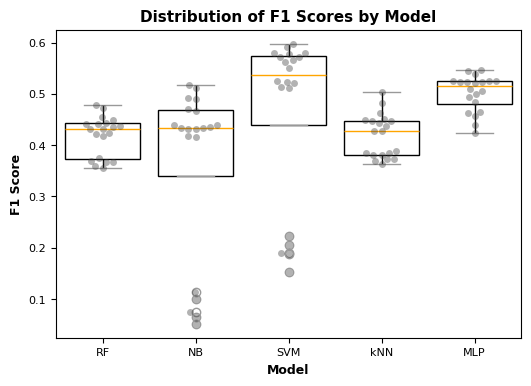

In [5]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=f1_df,
    x="Model",
    y="F1",
    color = "white",
    medianprops=dict(color='orange', linewidth=1),
    whiskerprops=dict(color='black', linewidth=1),
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=1),
    hue=None,
    legend=False
)
sns.swarmplot(
    data=f1_df,
    x="Model",
    y="F1",
    color=".25",
    alpha=0.4
)

plt.title("Distribution of F1 Scores by Model", fontweight='bold', fontsize=11)
plt.ylabel("F1 Score", fontweight='bold', fontsize=9)
plt.xlabel("Model", fontweight='bold', fontsize=9)
plt.tick_params(axis="x", labelsize=8)
plt.tick_params(axis="y", labelsize=8)
plt.show()

The results reveal the formation of two main performance groups. The first group, composed of RF, NB, and kNN, exhibits slightly lower F1 scores. This observation is consistent with the t-test outcomes, as the pairwise comparisons among these models show no statistically significant differences ($\text{p-value} \geq 0.05$), indicating that their performance is comparable. The second group, formed by SVM and MLP, achieves higher F1 scores, with significant differences when compared to the first group, as reflected in the t-values and p-values.

However, the direct comparison between SVM and MLP does not yield a statistically significant difference, with the adjusted p-value exceeding 0.05. Although the t-value suggests a slight advantage for MLP over SVM, the corresponding BF10 value is very low, indicating weak evidence for this difference. Consequently, these results do not allow a definitive choice between SVM and MLP based solely on their overall performance. 

<h2 id="preprocessing"><b>3.2. Preprocessing (Aggregation Technique)</b></h2>

In [6]:
posthoc_preproc = pg.pairwise_tests(
    data=f1_df,
    dv="F1",
    between="Preprocessing",
    padjust="bonf"
)

clean_posthoc(posthoc_preproc)

,Group 1,Group 2,t-value,p-value,p-value adj,Hedges g,BF10
0,Max Pooling,Mean Pooling,-1.1021,0.275893,1.000000,-0.307,0.465
1,Max Pooling,Sum Pooling,4.5293,0.000039,0.000235,1.261,496.411
2,Max Pooling,Truncate,3.4193,0.001290,0.007738,0.952,25.215
3,Mean Pooling,Sum Pooling,5.0790,0.000006,0.000037,1.414,2546.949
4,Mean Pooling,Truncate,4.8315,0.000014,0.000086,1.345,1207.47
5,Sum Pooling,Truncate,-2.9513,0.004883,0.029297,-0.822,8.527


,Group 1,Group 2,t-value,p-value,p-value adj,Hedges g,BF10
0,Max Pooling,Mean Pooling,-1.1021,0.275893,1.000000,-0.307,0.465
1,Max Pooling,Sum Pooling,4.5293,0.000039,0.000235,1.261,496.411
2,Max Pooling,Truncate,3.4193,0.001290,0.007738,0.952,25.215
3,Mean Pooling,Sum Pooling,5.0790,0.000006,0.000037,1.414,2546.949
4,Mean Pooling,Truncate,4.8315,0.000014,0.000086,1.345,1207.47
5,Sum Pooling,Truncate,-2.9513,0.004883,0.029297,-0.822,8.527


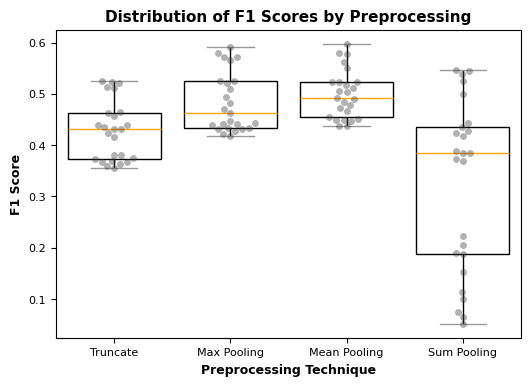

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=f1_df,
    x="Preprocessing",
    y="F1",
    color = "white",
    medianprops=dict(color='orange', linewidth=1),
    whiskerprops=dict(color='black', linewidth=1),
    boxprops=dict(facecolor='none', edgecolor='black', linewidth=1),
    hue=None,
    legend=False
)
sns.swarmplot(
    data=f1_df,
    x="Preprocessing",
    y="F1",
    color=".25",
    alpha=0.4
)

plt.title("Distribution of F1 Scores by Preprocessing", fontweight='bold', fontsize=11)
plt.ylabel("F1 Score", fontweight='bold', fontsize=9)
plt.xlabel("Preprocessing Technique", fontweight='bold', fontsize=9)
plt.tick_params(axis="x", labelsize=8)
plt.tick_params(axis="y", labelsize=8)
plt.show()

For the aggregation techniques, the results are much clearer, showing statistically significant differences ($\text{p-value} < 0.05$) between all techniques except for Max Pooling and Mean Pooling. These two methods exhibit the highest performance, as also observed in the figure. Focusing on the t-value (-1.1021), it indicates a slight advantage for Mean Pooling; however, since the difference is not statistically significant and the Bayes Factor (BF10) is very low, there is insufficient evidence to reject the null hypothesis. Therefore, it is not possible to select one method over the other based solely on these results.

<h2 id="interaction"><b>3.3. Interaction (Model x Preprocessing)</b></h2>

In [8]:
f1_df["Combination"] = f1_df["Model"] + " x " + f1_df["Preprocessing"]

posthoc_interaction = pg.pairwise_tests(
    data=f1_df,
    dv="F1",
    between="Combination",
    padjust="bonf"
)

interaction_df = clean_posthoc(posthoc_interaction)

,Group 1,Group 2,t-value,p-value,p-value adj,Hedges g,BF10
0,MLP x Max Pooling,MLP x Mean Pooling,0.3026,0.769910,1.000000,0.173,0.507
1,MLP x Max Pooling,MLP x Sum Pooling,-1.5236,0.166121,1.000000,-0.870,0.946
2,MLP x Max Pooling,MLP x Truncate,6.5048,0.000187,0.035561,3.716,100.658
3,MLP x Max Pooling,NB x Max Pooling,7.1479,0.000097,0.018485,4.083,170.327
4,MLP x Max Pooling,NB x Mean Pooling,1.7550,0.117332,1.000000,1.003,1.139
...,...,...,...,...,...,...,...
185,kNN x Max Pooling,kNN x Sum Pooling,4.6453,0.001655,0.314410,2.654,18.717
186,kNN x Max Pooling,kNN x Truncate,7.9647,0.000045,0.008565,4.550,319.085
187,kNN x Mean Pooling,kNN x Sum Pooling,4.4390,0.002171,0.412471,2.536,15.321
188,kNN x Mean Pooling,kNN x Truncate,6.8953,0.000125,0.023773,3.939,139.008


In [9]:
# Definir combinaciones de interés
combinations_of_interest = [
    "MLP x Max Pooling",
    "MLP x Mean Pooling",
    "SVM x Max Pooling",
    "SVM x Mean Pooling"
]

# Filtrar interaction_df para solo esas comparaciones
filtered_interaction_df = interaction_df[
    interaction_df["Group 1"].isin(combinations_of_interest) &
    interaction_df["Group 2"].isin(combinations_of_interest)
].reset_index(drop=True)

display(filtered_interaction_df)


,Group 1,Group 2,t-value,p-value,p-value adj,Hedges g,BF10
0,MLP x Max Pooling,MLP x Mean Pooling,0.3026,0.769910,1.000000,0.173,0.507
1,MLP x Max Pooling,SVM x Max Pooling,-8.1308,0.000039,0.007381,-4.645,360.623
2,MLP x Max Pooling,SVM x Mean Pooling,-5.7605,0.000424,0.080530,-3.291,52.816
3,MLP x Mean Pooling,SVM x Max Pooling,-7.1744,0.000095,0.018012,-4.098,173.945
4,MLP x Mean Pooling,SVM x Mean Pooling,-5.4721,0.000593,0.112669,-3.126,40.706
5,SVM x Max Pooling,SVM x Mean Pooling,0.2598,0.801585,1.000000,0.148,0.503


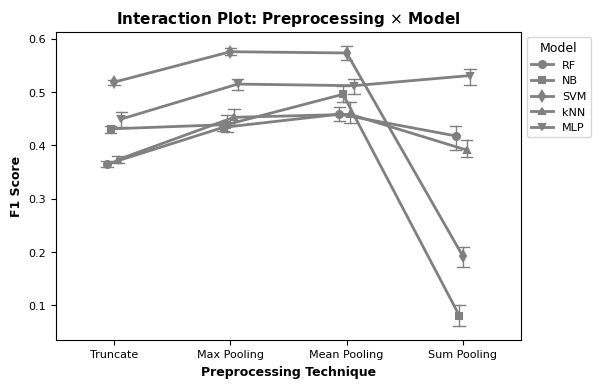

In [10]:
plt.figure(figsize=(6,4))
sns.pointplot(
    data=f1_df,
    x="Preprocessing",
    y="F1",
    hue="Model",
    dodge=True,
    markers=["o", "s", "d", "^", "v"],
    capsize=0.1,
    err_kws={'linewidth': 1},
    palette=["grey"]*5,
    linewidth = 2
)
plt.title("Interaction Plot: Preprocessing $\\times$ Model", fontweight='bold', fontsize=11)
plt.xlabel("Preprocessing Technique", fontweight='bold', fontsize=9)
plt.legend(title="Model", bbox_to_anchor=(1, 1), loc='upper left', fontsize=8).get_title().set_fontsize(9)
plt.ylabel("F1 Score", fontweight='bold', fontsize=9)
plt.tick_params(axis="x", labelsize=8)
plt.tick_params(axis="y", labelsize=8)
plt.show()

As previously determined, it is not possible to select a superior model between SVM and MLP, nor between Max and Mean Pooling based solely on their individual effects. Therefore, a Student's t-test was conducted considering the interaction between both factors, focusing on the six possible combinations of model and preprocessing. In this analysis, both the graphical representation and the statistical results clearly indicate the superiority of SVM in combination with Mean Pooling. Specifically, the t-test shows a statistically significant difference ($\text{p-value} < 0.05$), with a t-value of -5.4721, demonstrating a marked advantage of SVM over MLP when both are combined with Mean Pooling. This conclusion is further reinforced by the corresponding Bayes Factor ($BF10 = 40.706$), indicating strong evidence in favor of this difference. Furthermore, as illustrated in the figure, this combination exhibits a clear performance advantage compared to all other model-preprocessing combinations, highlighting its effectiveness in maximizing F1 scores.

<h2 id="conclusion"><b>4. Conclusion</b></h2>

The statistical analysis provides sufficient evidence to support the superiority of the combination of SVM with Mean Pooling. Both the post-hoc t-tests and the corresponding Bayes Factors indicate that this configuration consistently outperforms all other model-preprocessing combinations in terms of F1 score. These results suggest that SVM combined with Mean Pooling represents the most effective approach among the tested alternatives.

<h2 id="references"><b>5. References</b></h2>
<div style="margin: 1em;">
    <p id="ref-1">
        <b>[1]</b> <b>R. Vallat</b>, <i>Pingouin: statistics in Python</i>, Journal of Open Source Software, vol. 3, no. 31, p. 1026, 2018.  
        <br>
        &emsp; &ensp;[Online]. Available:  
        <a href="https://doi.org/10.21105/joss.01026" target="_blank">
            https://doi.org/10.21105/joss.01026
        </a>
    </p>
</div>